In [1]:
from baboo.simulation import SimulationModel
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt 
import scienceplots
from baboo.utils import write_tim_file, write_par
import libstempo



data_path = '/fred/oz022/tkimpson/synthetic_pulsar_residuals/data/'

In [7]:
#Define all functions

def get_F2(F0,F1,n):
    return (n*F1**2)/F0





def get_PSR_values_from_par(par):
    with open(par) as f:
        for line in f.readlines():
            line = line.strip()
            if line.split(' ')[0] == 'RAJ':
                RAJ=str(line.split()[1])
            if line.split(' ')[0] == 'DECJ':
                DECJ=str(line.split()[1])
            if line.split(' ')[0] == 'F0':
                F0=float(line.split()[1])
            if line.split(' ')[0] == 'F1':
                F1=float(line.split()[1].replace('D','E'))            
            if line.split(' ')[0] == 'START':
                t_START=float(line.split()[1])
            if line.split(' ')[0] == 'FINISH':
                t_FINISH=float(line.split()[1])
            if line.split(' ')[0] == 'NTOA':
                NTOA=int(line.split()[1])
    return 1.0,1.0,F0,F1,t_START,t_FINISH,NTOA










def get_F0_F1_F2_TempoNest(par):
    with open(par) as f:
        for line in f.readlines():
            line = line.strip()
            if line.split(' ')[0] == 'F2':
                F2=float(line.split()[1])
                F2_errs=float(line.split()[-1])
            if line.split(' ')[0] == 'F1':
                F1=float(line.split()[1])
            if line.split(' ')[0] == 'F0':
                F0=float(line.split()[1])
            if line.split(' ')[0] == 'TNRedAmp':
                RedAmp=float(line.split()[-1])
            if line.split(' ')[0] == 'TNRedGam':
                RedSlope=float(line.split()[-1])
    return F0,F1,F2,RedAmp,RedSlope






def create_files_get_psr(toas,toas_errors,pn,F0,F1,F2,RAJ,DECJ,psrj_nNoise_F2,out_prefix_nNoise_F2):
    ####
    write_tim_file(f'{out_prefix_nNoise_F2}',
                   toas, toas_errors, 
                   pn, observatory='BAT')
    write_par(f'{out_prefix_nNoise_F2}',
               F0, F1, toas[0], psrj=psrj_nNoise_F2, F2=F2,
               fit_F2=True, raj=RAJ, decj=DECJ, fit_pos=True)
    ###
    par_nN=f'{out_prefix_nNoise_F2}.par'
    tim_nN=f'{out_prefix_nNoise_F2}.tim'
    ####
    psr_TG=libstempo.tempopulsar(parfile=par_nN,
                                        timfile=tim_nN)
    return psr_TG





def get_REAL_psr(PSR,noNoise_params):
    psrj_F2=f"TimingDataRelease_UTMOST_PSR/{PSR}/{PSR}"
    if noNoise_params==True:
        par_file=f"{psrj_F2}_noAred_beta.par"
    else:
        par_file=f"{psrj_F2}.par"
    tim_file=f"{psrj_F2}.tim"
    psr_inst=libstempo.tempopulsar(parfile=par_file, timfile=tim_file)
    return psr_inst







def get_coords_rad_RA_DEC(RA,DEC):
    Coords=SkyCoord(RA,DEC, unit=(u.hourangle, u.deg),frame='icrs')
    return Coords.ra.rad, Coords.dec.rad



class EM_guided_mean_reverting_PTA_ModelSim(SimulationModel):
    """
    d(phi)/dt = F
    dF/dt = -gamma_F * F + gamma_F * Fbar(t) + xi(t)

    this gets translated in to F and N below
    We have put white noise in dF/dt and white noise amplitudes sigma_F.
    """

    nstates = 2
    def __init__(self, n, gamma_F, sigma_F, Fbar, F1bar, skipsize=1000):
        super(EM_guided_mean_reverting_PTA_ModelSim, self).__init__()
        self.gamma_F = gamma_F
        self.sigma_F = sigma_F
        self.Fbar = Fbar
        self.F1bar=F1bar
        self.n=n
        self.tau=-1*Fbar/((n-1)*F1bar)
        self.skipsize=skipsize
        # set up matrices
        # states are [phase, frequency]
        # also written as [phi, F]
        self.F = np.longdouble(np.array([[0., 1.],
                                         [0., -self.gamma_F]]))
        self.Q = np.longdouble(np.diag([0., np.sqrt(self.sigma_F)]))

    def expectation(self, x, t):
        ## Aux functions
        def Omega(Omega0,n,tau,t):
            frac=t/tau
            fac1=(1+frac)**(1/(1-n))
            return Omega0*fac1 
        def dOmega(dOmega0,n,tau,t):
            frac=t/tau
            fac1=(1+frac)**(n/(1-n))
            return dOmega0*fac1
        ## Secular evolution
        def N_step(t):
            return np.longdouble(np.array([0.,self.gamma_F*Omega(self.Fbar,self.n, self.tau,t)+
                                           dOmega(self.F1bar,self.n,self.tau,t)]))
        
        N_at_t=N_step(t)
        return self.F @ x + N_at_t

    def variance(self, x, t):
        return self.Q

# Study case: B1937+21

In [8]:
#def pulsar_pipeline(PSR_I)

In [9]:
pfile = "/fred/oz022/ldunn_psr/NANOGrav_12yv4_wideband/wideband/par/B1937+21_NANOGrav_12yv4.wb.gls.par"
RAJ,DECJ,F0,F1,t_START,t_FINISH,NTOA=get_PSR_values_from_par(pfile)
PSR_I="B1937+21"
#Observation times
Tobs=(t_FINISH-t_START)
Tobs_s=Tobs*24*60*60

#RA/DEC in radians
RA_rad,DEC_rad=get_coords_rad_RA_DEC(RAJ,DECJ)


#Get the second frequency derivative, assuming $n=3$
F2=get_F2(F0,F1,3)


#Define n and gamma
n_pl = 3
gamma_F = 1e-13

# Solution with some noise

In [17]:
p0_YP=[0.,F0]
sigma2_F1=1e-28
#sigma2_F1 = 0
print("Starting phase,F0",p0_YP,", respectively")
toa_errors_YP = (1e-7) * np.ones(NTOA)
times_YP = int(np.floor(t_START)) + np.sort(np.random.choice(np.arange(int(np.floor(t_FINISH-t_START))*100)/100.,
                                                                 size=NTOA, replace=False)).astype(float)
PSR_instantiation= EM_guided_mean_reverting_PTA_ModelSim(n_pl,gamma_F, sigma2_F1, F0, F1)
    # generate and fit frequencies
toas_MOD, toa_errors_MOD, states_with_Noise_MOD, pn_with_MOD =\
    PSR_instantiation.integrate_and_return_pn(times_YP, 
                                              F0, F1, times_YP[0], p0=p0_YP,
                                              toa_errors=toa_errors_YP, 
                                              Ntoas_per_fit=3, nphase_states=1)

Starting phase,F0 [0.0, 641.9282322943168] , respectively


100%|██████████| 524/524 [03:15<00:00,  2.68it/s]


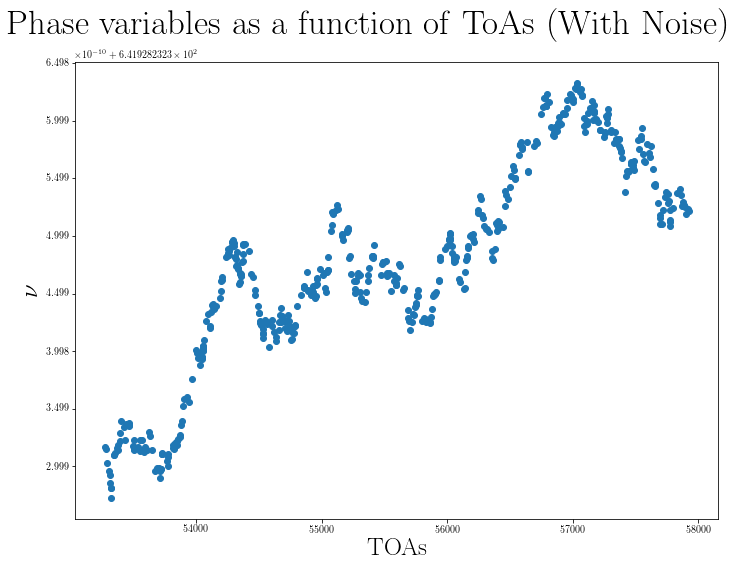

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
plt.rc('text', usetex=True)
axes.scatter(toas_MOD,states_with_Noise_MOD + [-F1*x - 0.5*F2*x**2 for x in (toas_MOD - toas_MOD[0])*86400])
axes.set_ylabel(r"$\nu$", fontsize=25)
axes.set_xlabel(r"${\rm TOAs}$", fontsize=25)
plt.suptitle(r"${\rm Phase~variables~as~a~function~of~ToAs~(With~Noise)}$", fontsize=35)
plt.tight_layout()
plt.show()

# Residual Comparison

In [19]:
# REAL PSR
#PSR_REAL=get_REAL_psr(PSR_I,noNoise_params=True)
PSR_REAL = libstempo.tempopulsar(parfile="/fred/oz022/ldunn_psr/NANOGrav_12yv4_wideband/wideband/par/B1937+21_NANOGrav_12yv4.wb.gls.par", timfile="/fred/oz022/ldunn_psr/NANOGrav_12yv4_wideband/wideband/tim/B1937+21_NANOGrav_12yv4.wb.tim")

<ipython-input-19-690c43ef1b85>:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PSR_REAL = libstempo.tempopulsar(parfile="/fred/oz022/ldunn_psr/NANOGrav_12yv4_wideband/wideband/par/B1937+21_NANOGrav_12yv4.wb.gls.par", timfile="/fred/oz022/ldunn_psr/NANOGrav_12yv4_wideband/wideband/tim/B1937+21_NANOGrav_12yv4.wb.tim")


In [20]:
out_prefix=f"data/fake_residuals/test"
FAKE_PSR=create_files_get_psr(toas_MOD, toa_errors_MOD,
                                   pn_with_MOD,F0,F1,F2,
                                       RAJ,DECJ,PSR_I,out_prefix)

<ipython-input-15-bc7bc0c09e42>:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr_TG=libstempo.tempopulsar(parfile=par_nN,


In [21]:

def create_files_get_psr(toas,toas_errors,pn,F0,F1,F2,RAJ,DECJ,psrj_nNoise_F2,out_prefix_nNoise_F2):
    ####
    write_tim_file(f'{out_prefix_nNoise_F2}',
                   toas, toas_errors, 
                   pn, observatory='BAT')
    write_par(f'{out_prefix_nNoise_F2}',
               F0, F1, toas[0], psrj=psrj_nNoise_F2, F2=F2,
               fit_F2=True, raj=RAJ, decj=DECJ, fit_pos=True)
    ###
    par_nN=f'{out_prefix_nNoise_F2}.par'
    tim_nN=f'{out_prefix_nNoise_F2}.tim'
    ####
    psr_TG=libstempo.tempopulsar(parfile=par_nN,
                                        timfile=tim_nN)
    return psr_TG




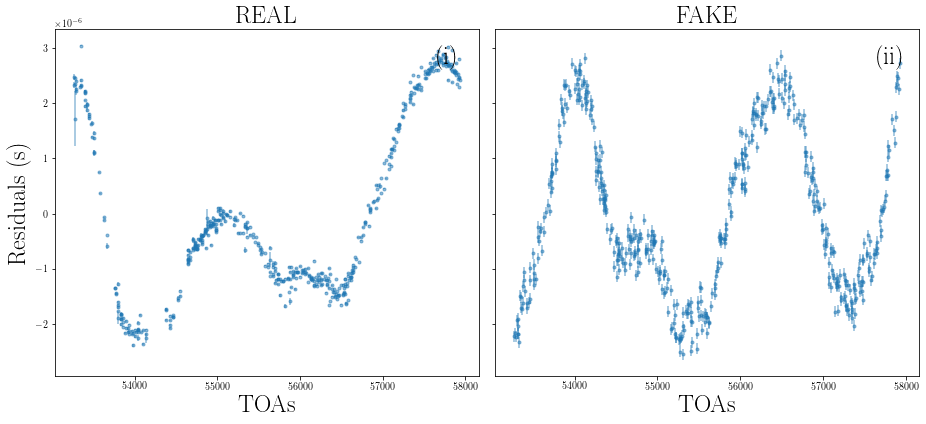

In [22]:
k = np.argsort(PSR_REAL.toas())
i = np.argsort(FAKE_PSR.toas())
###
PSR_REAL.fit()
FAKE_PSR.fit()
num1=PSR_I.split('J')[-1].split('-')[0]
num2=PSR_I.split('J')[-1].split('-')[-1]
#######################################################################
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6), sharey=True)
axes[0].errorbar(PSR_REAL.toas()[k],
                 PSR_REAL.residuals()[k],
                     yerr=1e-6*PSR_REAL.toaerrs[k],fmt='.',alpha=0.5 , label=r"${\rm REAL~}$"+r"${\rm J}$"\
                 +rf"${num1}-{num2}$")
axes[1].errorbar(FAKE_PSR.toas()[i],
                     FAKE_PSR.residuals()[i],
                     yerr=1e-6*FAKE_PSR.toaerrs[i],fmt='.',alpha=0.5, label=r"${\rm FAKE}$")
axes[0].set_ylabel(r'${\rm Residuals~(s)}$', fontsize=24)
axes[0].set_xlabel(r'${\rm TOAs}$', fontsize=24);
axes[1].set_xlabel(r'${\rm TOAs}$', fontsize=24);
axes[0].set_title(r'${\rm REAL}$', fontsize=24);
axes[0].text(0.9, 0.90, r'$({\rm i})$', transform=axes[0].transAxes, fontsize=24)
axes[1].set_title(r'${\rm FAKE}$', fontsize=24);
axes[1].text(0.9, 0.90, r'$({\rm ii})$', transform=axes[1].transAxes, fontsize=24)
plt.tight_layout()
plt.show()